# K-Nearest Neighbors (KNN) Image Classification

## Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tarfile
import urllib.request
import os
import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, matthews_corrcoef, confusion_matrix, 
                           roc_auc_score, roc_curve, classification_report)
from sklearn.preprocessing import label_binarize, StandardScaler

np.random.seed(42)

## CIFAR-10 Dataset

### About CIFAR-10:
- **Created by**: Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton at the University of Toronto
- **Source**: https://www.cs.toronto.edu/~kriz/cifar.html
- **Images**: 32×32 color images 
- **Classes**: 10 
- **Size**: 60,000 images total (50,000 training + 10,000 testing)

### Classes:
1. **Airplane** - Various aircraft types
2. **Automobile** - Cars, trucks, and other vehicles  
3. **Bird** - Different bird species
4. **Cat** - Domestic cats in various poses
5. **Deer** - Wild deer and similar animals
6. **Dog** - Various dog breeds
7. **Frog** - Frogs and toads
8. **Horse** - Horses in different settings
9. **Ship** - Naval vessels and boats
10. **Truck** - Large vehicles and trucks



## Download Dataset

In [ ]:
def download_cifar10():

    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    extracted_dir = "cifar-10-batches-py"
    
    if not os.path.exists("data"):
        os.makedirs("data")
    
    filepath = os.path.join("data", filename)
    extracted_path = os.path.join("data", extracted_dir)
    
    if os.path.exists(extracted_path):
        print("CIFAR-10 dataset already exists!")
        return extracted_path
    
    if not os.path.exists(filepath):
        print("Downloading CIFAR-10 dataset...")
        print(f"   Source: {url}")
        urllib.request.urlretrieve(url, filepath)
        print("Download completed!")

    print("Extracting dataset...")
    with tarfile.open(filepath, 'r:gz') as tar:
        tar.extractall("data")
    print("Extraction completed!")
    
    return extracted_path

def load_batch(file_path):
    with open(file_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    
    data = batch[b'data']
    labels = batch[b'labels']
    data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    
    return data, labels


def load_cifar10(data_dir):
    
    print("Loading CIFAR-10 dataset...")
    
    train_data = []
    train_labels = []
    
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        data, labels = load_batch(batch_file)
        train_data.append(data)
        train_labels.extend(labels)
    
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.array(train_labels)
    
    test_file = os.path.join(data_dir, 'test_batch')
    test_data, test_labels = load_batch(test_file)
    test_labels = np.array(test_labels)
    
    meta_file = os.path.join(data_dir, 'batches.meta')
    with open(meta_file, 'rb') as f:
        meta = pickle.load(f, encoding='bytes')
    class_names = [name.decode('utf-8') for name in meta[b'label_names']]
    
    print("Loaded successfully!")
    
    return (train_data, train_labels), (test_data, test_labels), class_names

In [3]:
data_dir = download_cifar10()
(X_train_full, y_train_full), (X_test, y_test), class_names = load_cifar10(data_dir)

CIFAR-10 dataset already exists!
Loading CIFAR-10 dataset...
Loaded successfully!


## Dataset Info

In [4]:
print(f"Training samples: {X_train_full.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Image shape: {X_train_full.shape[1:]} (Height × Width × Channels)")
print(f"Total features per image: {np.prod(X_train_full.shape[1:])}")
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")


unique, counts = np.unique(y_train_full, return_counts=True)
print(f"\nClass Distribution:")
for i, (class_idx, count) in enumerate(zip(unique, counts)):
    print(f"   {class_idx}. {class_names[class_idx]}: {count} samples")



Training samples: 50000
Test samples: 10000
Image shape: (32, 32, 3) (Height × Width × Channels)
Total features per image: 3072
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Class Distribution:
   0. airplane: 5000 samples
   1. automobile: 5000 samples
   2. bird: 5000 samples
   3. cat: 5000 samples
   4. deer: 5000 samples
   5. dog: 5000 samples
   6. frog: 5000 samples
   7. horse: 5000 samples
   8. ship: 5000 samples
   9. truck: 5000 samples


## Visualize CIFAR-10 Sample Data

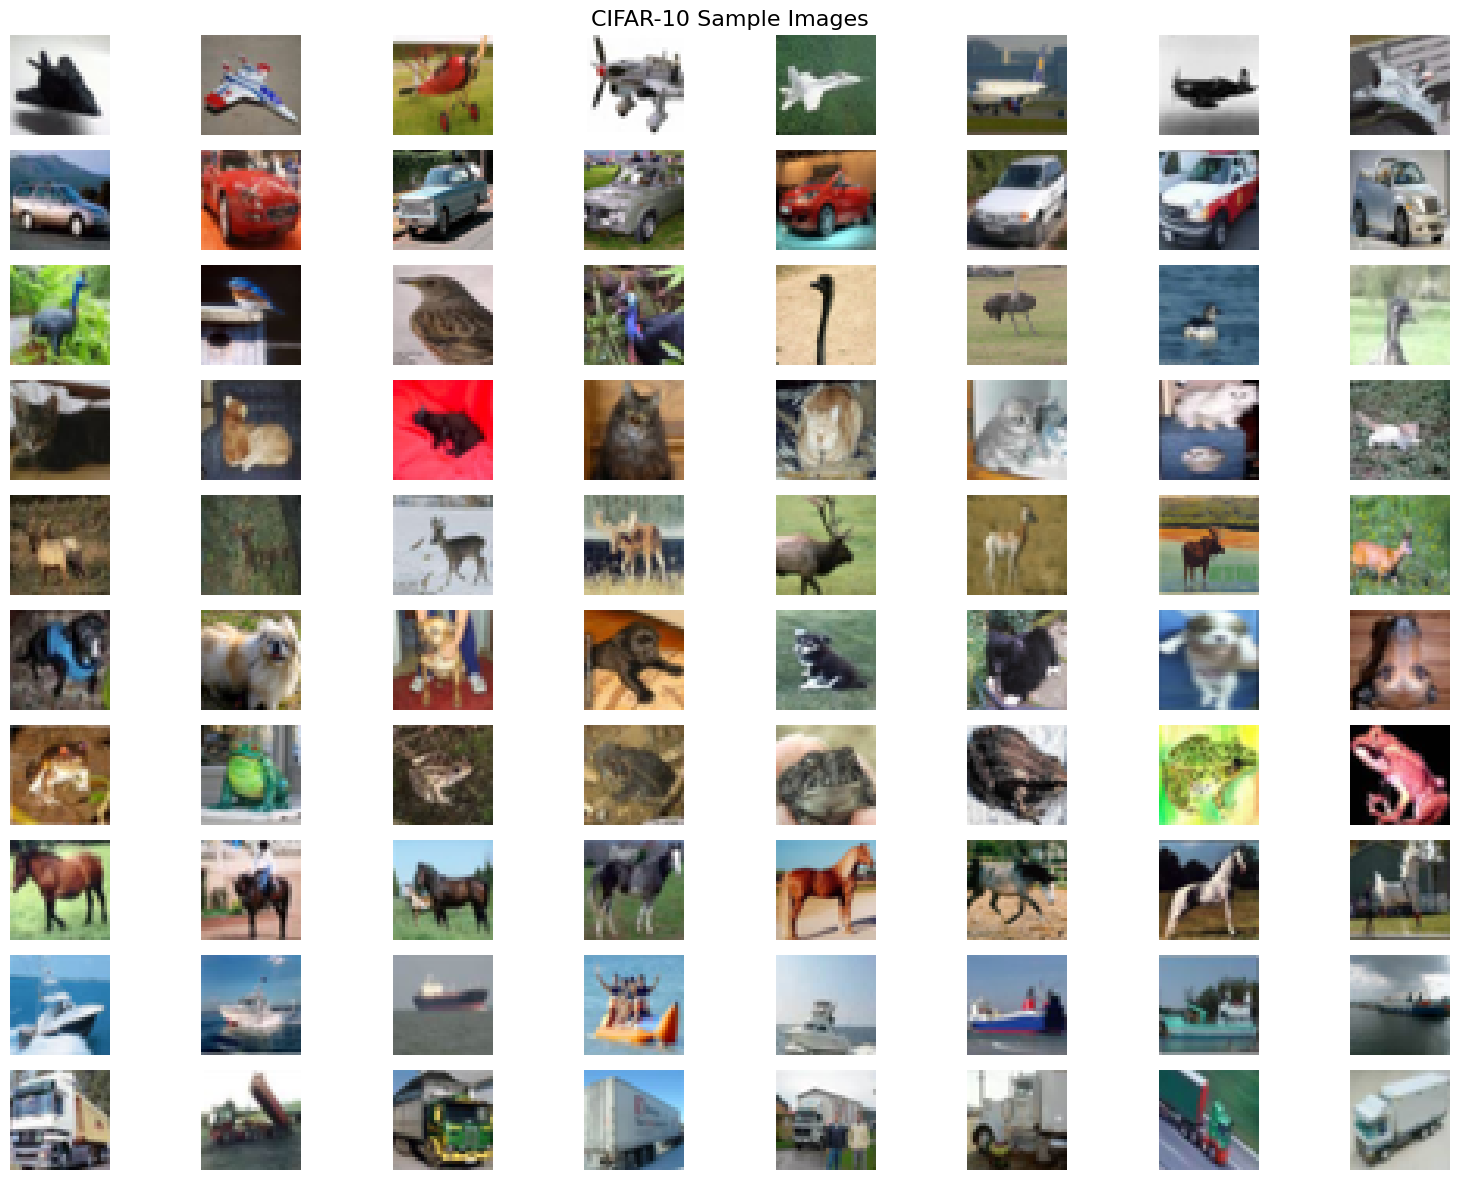

In [5]:
plt.figure(figsize=(16, 12))

for class_idx in range(10):
    class_indices = np.where(y_train_full == class_idx)[0]

    for i in range(8):
        plt.subplot(10, 8, class_idx * 8 + i + 1)
        image = X_train_full[class_indices[i]]
        
        plt.imshow(image)
        if i == 0: 
            plt.ylabel(f'{class_idx}: {class_names[class_idx]}', rotation=0, 
                      ha='right', va='center', fontsize=10)
        plt.axis('off')

plt.suptitle('CIFAR-10 Sample Images', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

## Image Statistics

Average pixel value (R): 125.3
Average pixel value (G): 123.0
Average pixel value (B): 113.9
Standard deviation: 64.2
Standard deviation: 64.2


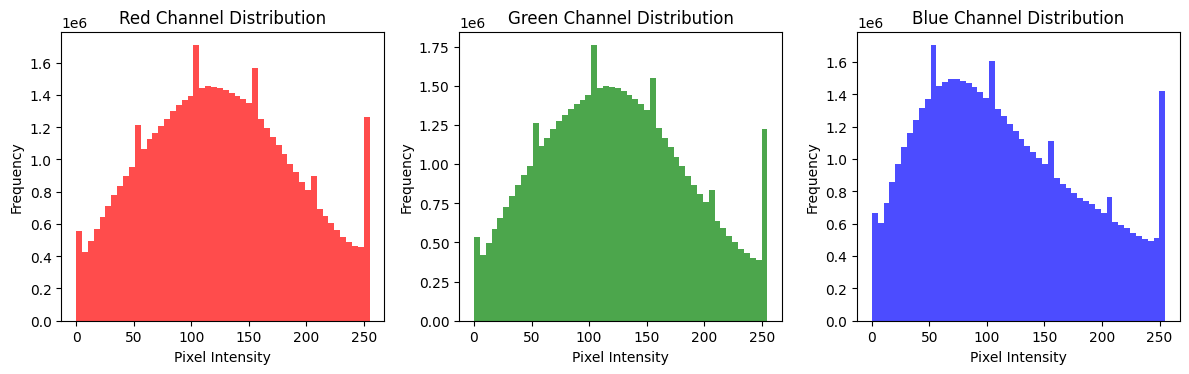

In [6]:
print(f"Average pixel value (R): {X_train_full[:,:,:,0].mean():.1f}")
print(f"Average pixel value (G): {X_train_full[:,:,:,1].mean():.1f}")
print(f"Average pixel value (B): {X_train_full[:,:,:,2].mean():.1f}")
print(f"Standard deviation: {X_train_full.std():.1f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(X_train_full[:,:,:,0].flatten(), bins=50, alpha=0.7, color='red', label='Red')
plt.title('Red Channel Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(X_train_full[:,:,:,1].flatten(), bins=50, alpha=0.7, color='green', label='Green')
plt.title('Green Channel Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(X_train_full[:,:,:,2].flatten(), bins=50, alpha=0.7, color='blue', label='Blue')
plt.title('Blue Channel Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Data Preprocessing and Splitting

In [7]:
X_train_flat = X_train_full.reshape(X_train_full.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Original Train shape: {X_train_full.shape}")
print(f"Flattened Train shape: {X_train_flat.shape}")

print(f"Original Test shape: {X_test.shape}")
print(f"Flattened Test shape: {X_test_flat.shape}")

Original Train shape: (50000, 32, 32, 3)
Flattened Train shape: (50000, 3072)
Original Test shape: (10000, 32, 32, 3)
Flattened Test shape: (10000, 3072)


### 80% Training and 20% Validation 

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_flat, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_train_flat)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X_train_flat)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 40000 samples (80.0%)
Validation set: 10000 samples (20.0%)
Test set: 10000 samples


### Normalizing pixel values

In [9]:
print(f"Original range: [{X_train.min()}, {X_train.max()}]")

X_train_scaled = X_train.astype('float32') / 255.0
X_val_scaled = X_val.astype('float32') / 255.0
X_test_scaled = X_test_flat.astype('float32') / 255.0

print(f"Normalized range: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")

Original range: [0, 255]
Normalized range: [0.000, 1.000]
Normalized range: [0.000, 1.000]


### Scaling

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_val_scaled = scaler.transform(X_val_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

print(f"After standardization: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")
print(f"Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.6f}")

After standardization: [-2.204, 2.617]
Mean: 0.000000, Std: 1.000000
Mean: 0.000000, Std: 1.000000


## Understanding the K Parameter for CIFAR-10

The choice of **K** is even more critical for CIFAR-10 due to its complexity:

### CIFAR-10 Specific Considerations:
- **High dimensionality**: 3072 features make distance calculations more complex
- **Curse of dimensionality**: In high dimensions, all points tend to be equidistant
- **Class complexity**: Natural images have much more variation than simple digits
- **Computational cost**: Each prediction requires calculating 3072-dimensional distances

### How K affects KNN behavior on CIFAR-10:
- **K = 1**: Very sensitive to outliers and mislabeled data
- **Small K (3-7)**: Captures local patterns but may overfit to noise
- **Medium K (9-15)**: Balances local and global information
- **Large K (>20)**: May average out important local features

### Finding the optimal K for CIFAR-10:
We'll use **Grid Search with Cross-Validation** but with fewer K values due to computational constraints. For real-world applications, you might need to balance accuracy with computational resources.

In [11]:
print("Finding optimal K value for CIFAR-10...")

k_values = [1, 3, 5, 7, 9, 11, 15]

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid={'n_neighbors': k_values},
    cv=3, 
    scoring='accuracy',
    n_jobs=-1, 
    verbose=1  
)

start_time = time.time()

knn_grid.fit(X_train_scaled, y_train)

end_time = time.time()
print(f"Search completed in {end_time - start_time:.1f} seconds")

best_k = knn_grid.best_params_['n_neighbors']
best_score = knn_grid.best_score_

# print(f"Best K value for CIFAR-10: {best_k}")
# print(f"Best cross-validation accuracy: {best_score:.4f}")


Finding optimal K value for CIFAR-10...
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Search completed in 571.4 seconds
Search completed in 571.4 seconds


In [12]:
print(f"Performance for different K values on CIFAR-10:")
results = []
for k in k_values:
    idx = np.where(knn_grid.cv_results_['param_n_neighbors'] == k)[0][0]
    score = knn_grid.cv_results_['mean_test_score'][idx]
    std = knn_grid.cv_results_['std_test_score'][idx]
    fit_time = knn_grid.cv_results_['mean_fit_time'][idx]
    score_time = knn_grid.cv_results_['mean_score_time'][idx]
    results.append((k, score, std, fit_time, score_time))
    print(f"   K={k:2d}: {score:.4f} ± {std:.4f} (fit: {fit_time:.2f}s, score: {score_time:.2f}s)")

print(f"Optimal K found: {best_k}")

Performance for different K values on CIFAR-10:
   K= 1: 0.3238 ± 0.0040 (fit: 0.83s, score: 267.95s)
   K= 3: 0.3105 ± 0.0036 (fit: 0.83s, score: 271.06s)
   K= 5: 0.3175 ± 0.0016 (fit: 0.82s, score: 273.52s)
   K= 7: 0.3198 ± 0.0021 (fit: 0.83s, score: 269.71s)
   K= 9: 0.3192 ± 0.0012 (fit: 1.54s, score: 292.25s)
   K=11: 0.3188 ± 0.0005 (fit: 1.48s, score: 288.90s)
   K=15: 0.3182 ± 0.0024 (fit: 1.35s, score: 288.96s)
Optimal K found: 1


## Visualize K Parameter Selection

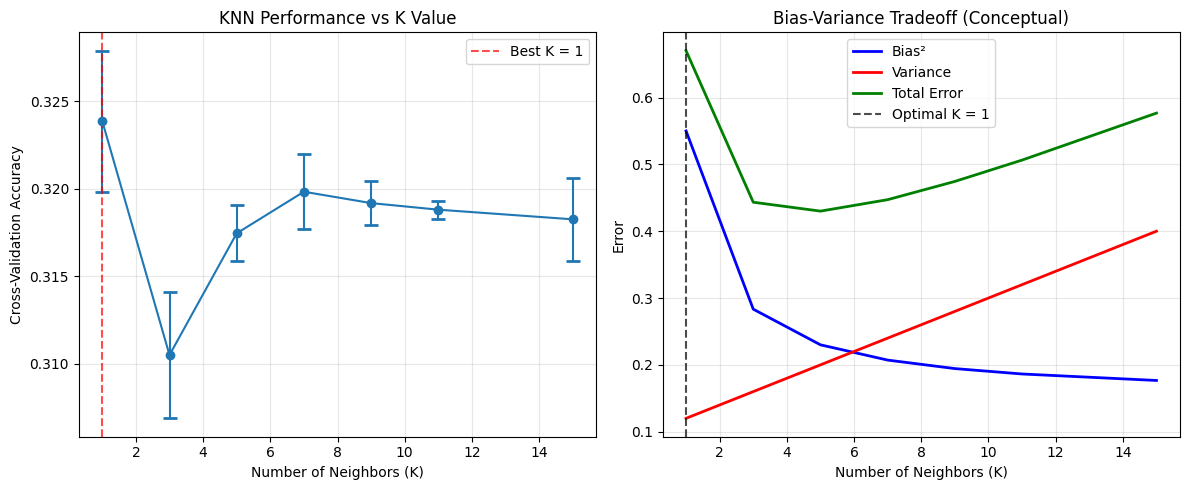

Key Insights from K Selection:
    Optimal K = 1 balances bias and variance
 Small K: Low bias, high variance (overfitting)
 Large K: High bias, low variance (underfitting)


In [13]:
plt.figure(figsize=(12, 5))

k_vals = [r[0] for r in results]
scores = [r[1] for r in results]
stds = [r[2] for r in results]

plt.subplot(1, 2, 1)
plt.errorbar(k_vals, scores, yerr=stds, marker='o', capsize=5, capthick=2)
plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'Best K = {best_k}')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('KNN Performance vs K Value')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
k_range = np.array(k_vals)
bias = 0.15 + 0.4 * (1 / k_range) 
variance = 0.1 + 0.3 * (k_range / max(k_range)) 
total_error = bias + variance

plt.plot(k_range, bias, 'b-', label='Bias²', linewidth=2)
plt.plot(k_range, variance, 'r-', label='Variance', linewidth=2)
plt.plot(k_range, total_error, 'g-', label='Total Error', linewidth=2)
plt.axvline(x=best_k, color='black', linestyle='--', alpha=0.7, label=f'Optimal K = {best_k}')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Error')
plt.title('Bias-Variance Tradeoff (Conceptual)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Insights from K Selection:")
print(f"    Optimal K = {best_k} balances bias and variance")
print(" Small K: Low bias, high variance (overfitting)")
print(" Large K: High bias, low variance (underfitting)")

## Final Training 

In [14]:
knn_final = KNeighborsClassifier(n_neighbors=best_k)
print("Training KNN...")
knn_final.fit(X_train_scaled, y_train)

Training KNN...


,n_neighbors,1
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


## Make predictions

In [15]:
start_time = time.time()
y_val_pred = knn_final.predict(X_val_scaled)
val_time = time.time() - start_time

start_time = time.time()
y_test_pred = knn_final.predict(X_test_scaled)
test_time = time.time() - start_time

In [16]:
y_val_proba = knn_final.predict_proba(X_val_scaled)
y_test_proba = knn_final.predict_proba(X_test_scaled)

In [17]:
print("Predictions completed")
print(f"    Validation predictions: {len(y_val_pred)} samples ({val_time:.2f}s)")
print(f"    Test predictions: {len(y_test_pred)} samples ({test_time:.2f}s)")


Predictions completed
    Validation predictions: 10000 samples (38.06s)
    Test predictions: 10000 samples (42.22s)


In [18]:
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Quick Results on CIFAR-10:")
print(f"    Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"    Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

print(f"Comparison Context:")
print(f"    Random guessing (10 classes): ~10% accuracy")
print(f"    Simple heuristics: ~20-30% accuracy")
print(f"    KNN performance: {test_accuracy*100:.1f}% accuracy")
print(f"    State-of-the-art CNNs: ~95%+ accuracy")
print(f"    Human performance: ~94% accuracy")

Quick Results on CIFAR-10:
    Validation Accuracy: 0.3443 (34.43%)
    Test Accuracy: 0.3454 (34.54%)
Comparison Context:
    Random guessing (10 classes): ~10% accuracy
    Simple heuristics: ~20-30% accuracy
    KNN performance: 34.5% accuracy
    State-of-the-art CNNs: ~95%+ accuracy
    Human performance: ~94% accuracy


## Evaluation

In [19]:
def evaluate_model_cifar10(y_true, y_pred, dataset_name):
    
    print(f"\n{'='*60}")
    print(f"{dataset_name} Set Evaluation Results (CIFAR-10)")
    print(f"{'='*60}")
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    mcc = matthews_corrcoef(y_true, y_pred)
    

    print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f} (macro-averaged)")
    print(f"Recall:    {recall:.4f} (macro-averaged)")
    print(f"F1-Score:  {f1:.4f} (macro-averaged)")
    print(f"MCC:       {mcc:.4f} (Matthew's Correlation)")
    
    cm = confusion_matrix(y_true, y_pred)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)

    print(f"Per-Class Performance:")
    for i, acc in enumerate(class_accuracy):
        print(f"   {class_names[i]:12s}: {acc:.3f} ({acc*100:.1f}%)")
    
    best_class_idx = np.argmax(class_accuracy)
    worst_class_idx = np.argmin(class_accuracy)
    
    print(f"Best performing class:  {class_names[best_class_idx]} ({class_accuracy[best_class_idx]*100:.1f}%)")
    print(f"Worst performing class: {class_names[worst_class_idx]} ({class_accuracy[worst_class_idx]*100:.1f}%)")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'mcc': mcc,
        'class_accuracy': class_accuracy
    }

In [20]:
val_metrics = evaluate_model_cifar10(y_val, y_val_pred, "Validation")
test_metrics = evaluate_model_cifar10(y_test, y_test_pred, "Test")

print(f"CIFAR-10 Model Performance Summary:")
print(f"    Validation accuracy: {val_metrics['accuracy']:.4f}")
print(f"    Test accuracy: {test_metrics['accuracy']:.4f}")
print(f"    Difference: {abs(val_metrics['accuracy'] - test_metrics['accuracy']):.4f}")

if abs(val_metrics['accuracy'] - test_metrics['accuracy']) < 0.03:
    print("Good generalization (small gap between validation and test)")
else:
    print("Possible overfitting (large gap between validation and test)")


Validation Set Evaluation Results (CIFAR-10)
Accuracy:  0.3443 (34.43%)
Precision: 0.3988 (macro-averaged)
Recall:    0.3443 (macro-averaged)
F1-Score:  0.3356 (macro-averaged)
MCC:       0.2759 (Matthew's Correlation)
Per-Class Performance:
   airplane    : 0.477 (47.7%)
   automobile  : 0.188 (18.8%)
   bird        : 0.373 (37.3%)
   cat         : 0.254 (25.4%)
   deer        : 0.487 (48.7%)
   dog         : 0.255 (25.5%)
   frog        : 0.331 (33.1%)
   horse       : 0.279 (27.9%)
   ship        : 0.636 (63.6%)
   truck       : 0.163 (16.3%)
Best performing class:  ship (63.6%)
Worst performing class: truck (16.3%)

Test Set Evaluation Results (CIFAR-10)
Accuracy:  0.3454 (34.54%)
Precision: 0.4032 (macro-averaged)
Recall:    0.3454 (macro-averaged)
F1-Score:  0.3399 (macro-averaged)
MCC:       0.2768 (Matthew's Correlation)
Per-Class Performance:
   airplane    : 0.479 (47.9%)
   automobile  : 0.215 (21.5%)
   bird        : 0.379 (37.9%)
   cat         : 0.235 (23.5%)
   deer    

## Confusion Matrix Analysis

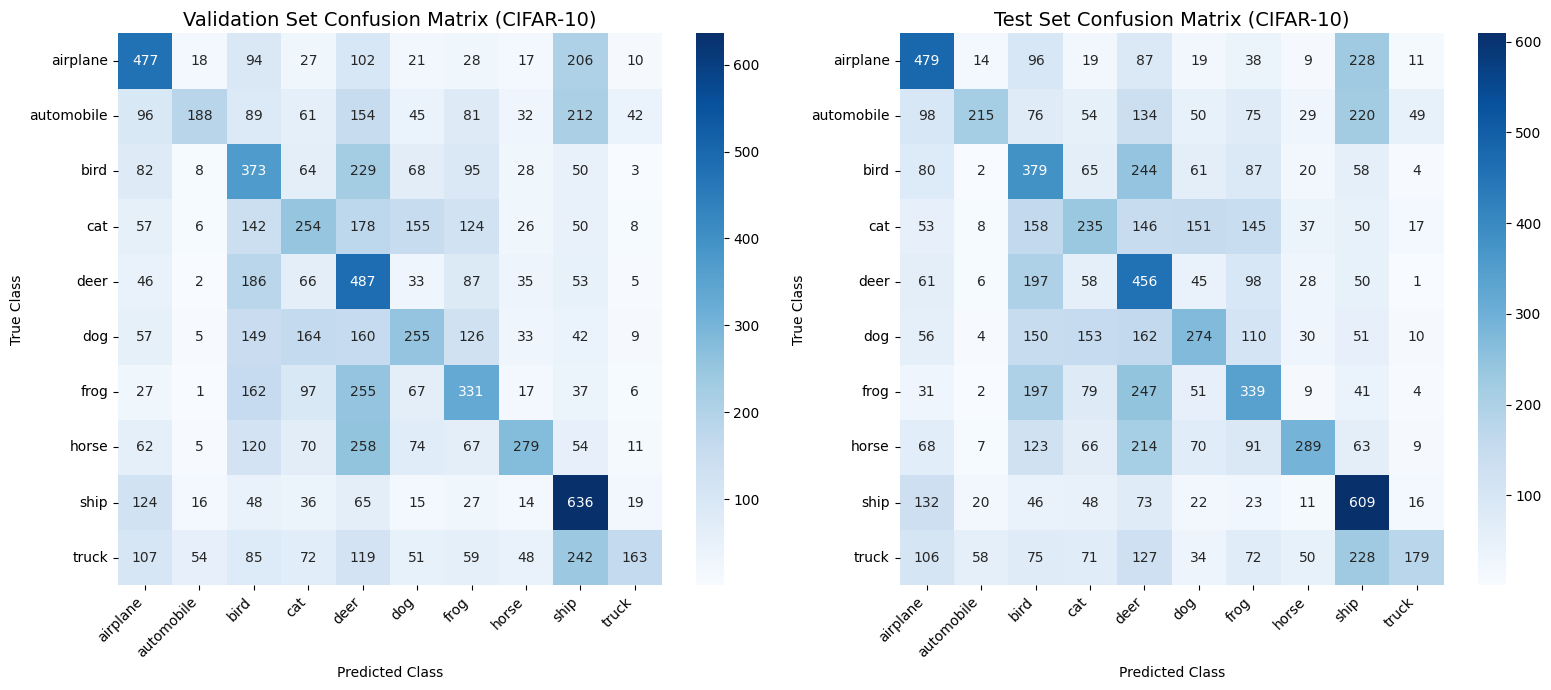

In [21]:
cm_val = confusion_matrix(y_val, y_val_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Validation Set Confusion Matrix (CIFAR-10)', fontsize=14)
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Test Set Confusion Matrix (CIFAR-10)', fontsize=14)
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

In [22]:
def find_most_confused_pairs_cifar10(cm, dataset_name):
    print(f"\n{dataset_name} Set - Most Confused CIFAR-10 Class Pairs:")
    
    cm_off_diag = cm.copy()
    np.fill_diagonal(cm_off_diag, 0)
    
    flat_indices = np.argsort(cm_off_diag.ravel())[-8:][::-1]
    
    for i, flat_idx in enumerate(flat_indices):
        row, col = np.unravel_index(flat_idx, cm_off_diag.shape)
        confusion_count = cm[row, col]
        if confusion_count > 0:
            print(f"   {i+1}. {class_names[row]} → {class_names[col]}: {confusion_count} times")

find_most_confused_pairs_cifar10(cm_val, "Validation")
find_most_confused_pairs_cifar10(cm_test, "Test")

print(f"Per-Class Accuracy Analysis (Test Set):")
class_accuracy = cm_test.diagonal() / cm_test.sum(axis=1)

high_perf = []
med_perf = []
low_perf = []

for i, acc in enumerate(class_accuracy):
    print(f"   {class_names[i]:12s}: {acc:.3f} ({acc*100:.1f}%)")
    if acc > 0.6:
        high_perf.append(class_names[i])
    elif acc > 0.4:
        med_perf.append(class_names[i])
    else:
        low_perf.append(class_names[i])

print(f"Performance Categories:")
if high_perf:
    print(f"    High performers (>60%): {', '.join(high_perf)}")
if med_perf:
    print(f"    Medium performers (40-60%): {', '.join(med_perf)}")
if low_perf:
    print(f"    Low performers (<40%): {', '.join(low_perf)}")


Validation Set - Most Confused CIFAR-10 Class Pairs:
   1. horse → deer: 258 times
   2. frog → deer: 255 times
   3. truck → ship: 242 times
   4. bird → deer: 229 times
   5. automobile → ship: 212 times
   6. airplane → ship: 206 times
   7. deer → bird: 186 times
   8. cat → deer: 178 times

Test Set - Most Confused CIFAR-10 Class Pairs:
   1. frog → deer: 247 times
   2. bird → deer: 244 times
   3. airplane → ship: 228 times
   4. truck → ship: 228 times
   5. automobile → ship: 220 times
   6. horse → deer: 214 times
   7. frog → bird: 197 times
   8. deer → bird: 197 times
Per-Class Accuracy Analysis (Test Set):
   airplane    : 0.479 (47.9%)
   automobile  : 0.215 (21.5%)
   bird        : 0.379 (37.9%)
   cat         : 0.235 (23.5%)
   deer        : 0.456 (45.6%)
   dog         : 0.274 (27.4%)
   frog        : 0.339 (33.9%)
   horse       : 0.289 (28.9%)
   ship        : 0.609 (60.9%)
   truck       : 0.179 (17.9%)
Performance Categories:
    High performers (>60%): ship
    

## ROC Curve Analysis

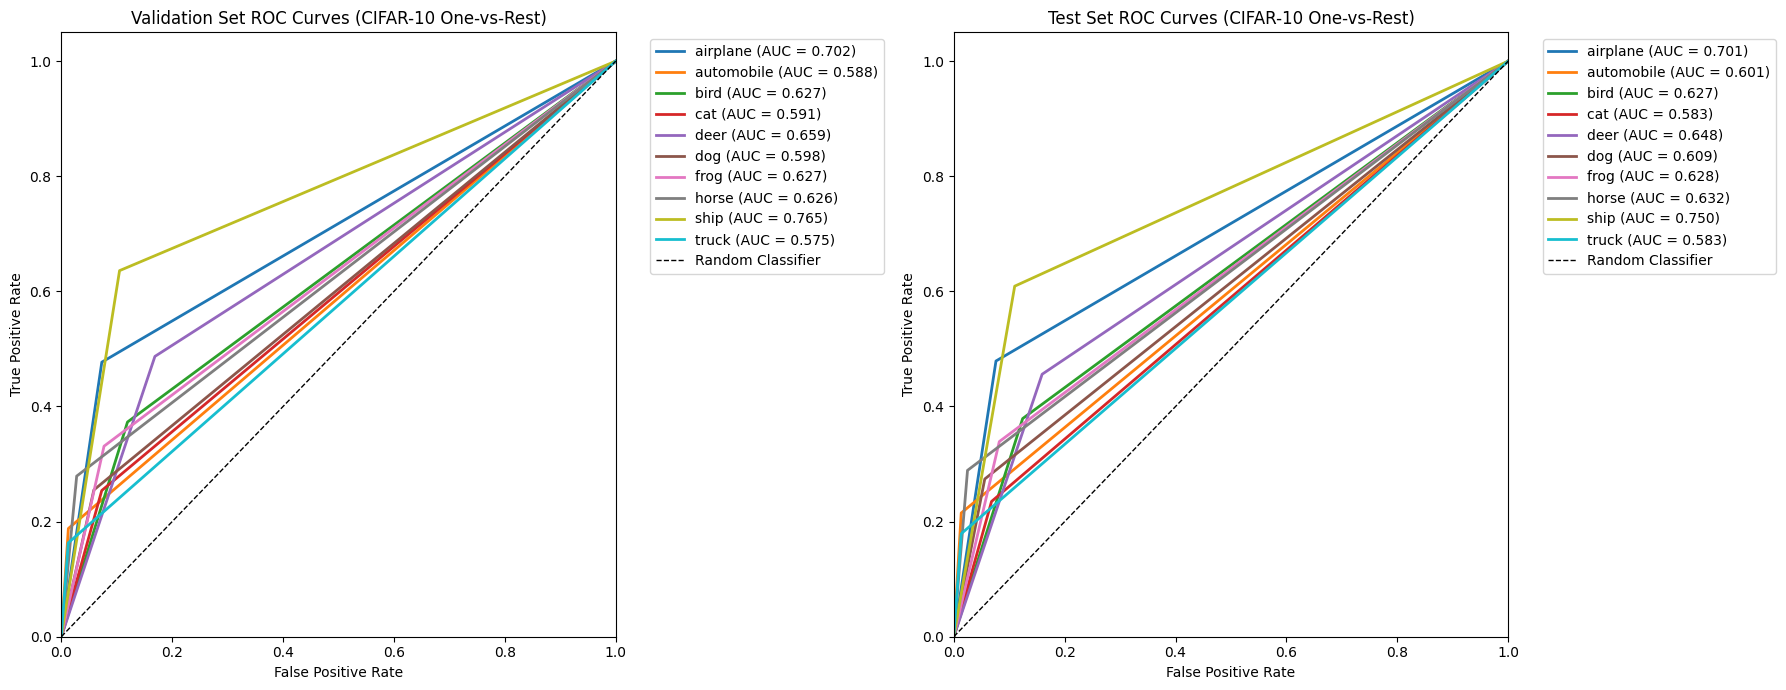

 Overall ROC AUC Scores for CIFAR-10 (Macro-Averaged):
    Validation AUC: 0.6357
    Test AUC: 0.6363
Individual Class AUC Scores (Test Set):
   airplane    : 0.701
   automobile  : 0.601
   bird        : 0.627
   cat         : 0.583
   deer        : 0.648
   dog         : 0.609
   frog        : 0.628
   horse       : 0.632
   ship        : 0.750
   truck       : 0.583
Best AUC performance:  ship (0.750)
Worst AUC performance: truck (0.583)


In [23]:
y_val_binary = label_binarize(y_val, classes=range(10))
y_test_binary = label_binarize(y_test, classes=range(10))

plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_val_binary[:, i], y_val_proba[:, i])
    roc_auc = roc_auc_score(y_val_binary[:, i], y_val_proba[:, i])
    plt.plot(fpr, tpr, color=color, linewidth=2,
             label=f'{class_names[i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation Set ROC Curves (CIFAR-10 One-vs-Rest)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(1, 2, 2)
for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_test_binary[:, i], y_test_proba[:, i])
    roc_auc = roc_auc_score(y_test_binary[:, i], y_test_proba[:, i])
    plt.plot(fpr, tpr, color=color, linewidth=2,
             label=f'{class_names[i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Curves (CIFAR-10 One-vs-Rest)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

val_auc = roc_auc_score(y_val_binary, y_val_proba, multi_class='ovr', average='macro')
test_auc = roc_auc_score(y_test_binary, y_test_proba, multi_class='ovr', average='macro')

print(f" Overall ROC AUC Scores for CIFAR-10 (Macro-Averaged):")
print(f"    Validation AUC: {val_auc:.4f}")
print(f"    Test AUC: {test_auc:.4f}")


print(f"Individual Class AUC Scores (Test Set):")
class_aucs = []
for i in range(10):
    auc = roc_auc_score(y_test_binary[:, i], y_test_proba[:, i])
    class_aucs.append(auc)
    print(f"   {class_names[i]:12s}: {auc:.3f}")


best_auc_idx = np.argmax(class_aucs)
worst_auc_idx = np.argmin(class_aucs)

print(f"Best AUC performance:  {class_names[best_auc_idx]} ({class_aucs[best_auc_idx]:.3f})")
print(f"Worst AUC performance: {class_names[worst_auc_idx]} ({class_aucs[worst_auc_idx]:.3f})")

## Cross-Validation Analysis

In [25]:
print("Performing 5-Fold Cross-Validation Analysis...")
from sklearn.model_selection import cross_validate

scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']


cv_results_dict = cross_validate(
    knn_final, X_train_scaled, y_train, 
    cv=5, 
    scoring=scoring_metrics, 
    n_jobs=-1,
    return_train_score=False 
)


cv_results = {}
for metric in scoring_metrics:
    test_key = f'test_{metric}'
    cv_results[metric] = cv_results_dict[test_key]
    
    scores = cv_results[metric]
    mean_score = scores.mean()
    std_score = scores.std()
    
    print(f"{metric.replace('_', ' ').title()}:")
    print(f"   Mean: {mean_score:.4f}")
    print(f"   Std:  {std_score:.4f}")
    print(f"   95% CI: [{mean_score - 1.96*std_score:.4f}, {mean_score + 1.96*std_score:.4f}]")
    print(f"   Individual folds: {[f'{s:.4f}' for s in scores]}")

print(f"Cross-validation completed efficiently using single data pass!")


Performing 5-Fold Cross-Validation Analysis...
Accuracy:
   Mean: 0.3293
   Std:  0.0068
   95% CI: [0.3159, 0.3427]
   Individual folds: ['0.3280', '0.3425', '0.3279', '0.3249', '0.3232']
Precision Macro:
   Mean: 0.3874
   Std:  0.0064
   95% CI: [0.3749, 0.4000]
   Individual folds: ['0.3889', '0.3988', '0.3808', '0.3866', '0.3820']
Recall Macro:
   Mean: 0.3293
   Std:  0.0068
   95% CI: [0.3159, 0.3427]
   Individual folds: ['0.3280', '0.3425', '0.3279', '0.3249', '0.3232']
F1 Macro:
   Mean: 0.3234
   Std:  0.0068
   95% CI: [0.3100, 0.3368]
   Individual folds: ['0.3216', '0.3366', '0.3227', '0.3190', '0.3172']
Cross-validation completed efficiently using single data pass!
Accuracy:
   Mean: 0.3293
   Std:  0.0068
   95% CI: [0.3159, 0.3427]
   Individual folds: ['0.3280', '0.3425', '0.3279', '0.3249', '0.3232']
Precision Macro:
   Mean: 0.3874
   Std:  0.0064
   95% CI: [0.3749, 0.4000]
   Individual folds: ['0.3889', '0.3988', '0.3808', '0.3866', '0.3820']
Recall Macro:
   Mea